<div style="text-align:center; background-color:#F3E5F5; padding: 20px; border-radius: 10px;">
  <span style="color:#4C6A92; font-size:38px; font-weight:bold;">CNN-Based Metal Surface Defect Classifier</span>
</div>

<span style="color:#4C6A92; font-size:32px; font-weight:bold;">Key Stages of Metal Surface Defect Detection Using CNN</span>

<span style="color:#28A745; font-weight:bold;">1) Problem Statement</span>

Define the objective of detecting and classifying metal surface defects using deep learning.<br>

<span style="color:#28A745; font-weight:bold;">2) Data Collection</span>

Use the NEU Metal Surface Defects dataset, which contains six defect types.<br>

<span style="color:#28A745; font-weight:bold;">3) Exploratory Data Analysis (EDA)</span>

Visualize sample images and analyze class distributions to understand dataset characteristics.<br>

<span style="color:#28A745; font-weight:bold;">4) Data Preprocessing</span>

Resize, normalize, and augment images to improve model generalization.<br>

<span style="color:#28A745; font-weight:bold;">5) Model Building</span>

Define a custom CNN model and utilize pretrained architectures like VGG16, ResNet50, MobileNetV2, and EfficientNetB0 for transfer learning.<br>

<span style="color:#28A745; font-weight:bold;">6) Preparing Callbacks</span>

Implement early stopping, model checkpointing, and learning rate scheduling to optimize training efficiency and prevent overfitting.<br>

<span style="color:#28A745; font-weight:bold;">7) Base Model Training, Evaluation and Selecting the Best Performing Base Model</span>

Train the CNN models and evaluate performance using accuracy, precision, recall, and F1-score.<br>

<span style="color:#28A745; font-weight:bold;">8) Hyperparameter Tuning</span>

Identify the best-performing model based on evaluation metrics and fine-tune hyperparameters to enhance classification accuracy.<br>

<span style="color:#28A745; font-weight:bold;">9) Prediction for a Single Image</span>

Implement a function to classify new images and return predictions with confidence scores.<br>

<span style="color:#28A745; font-weight:bold;">10) Building the Application</span>

Develop a web interface allowing users to upload images and get defect classifications.<br>

<span style="color:#28A745; font-weight:bold;">11) Deployment</span>

Deploy the trained model using Streamlit and host the application on Render for real-world accessibility and interaction.<br>


<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">1) Problem Statement</span>
</div>

In the manufacturing industry, detecting surface defects in metal components is essential for ensuring product quality and reducing material waste. Manual inspection is time-consuming, prone to human error, and inefficient for large-scale production. Automated defect detection using deep learning can significantly improve accuracy and speed in identifying surface defects. <br>

This project aims to develop a convolutional neural network (CNN) model to classify different types of metal surface defects. The model is trained using the NEU Metal Surface Defects dataset and evaluates both custom CNN architectures and pretrained models such as VGG16, ResNet50, MobileNetV2, and EfficientNetB0. The goal is to create a robust and efficient classification system that enhances quality control processes in industrial settings. The trained model is deployed using Streamlit and hosted on Render, allowing for real-time defect classification through a user-friendly interface.

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">2) Data Collection</span>
</div>

### Dataset Information    

- Source: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data

The dataset used in this project is the **NEU Metal Surface Defects Database**, which consists of **1,800 grayscale images** representing six common types of defects found in hot-rolled steel strips. These defect types include:  

- **Rolled-in Scale (RS)**  
- **Patches (Pa)**  
- **Crazing (Cr)**  
- **Pitted Surface (PS)**  
- **Inclusion (In)**  
- **Scratches (Sc)**  

Each defect class has **300 images**, ensuring an equal distribution across categories. The images capture real-world manufacturing defects and serve as the foundation for training, validating, and testing the deep learning models.  

The dataset is organized into three directories:  

- **Train Folder**: Contains six subfolders, each corresponding to a defect type, with **276 images per class** for training.  
- **Validation Folder**: Contains six subfolders, each with **12 images per class** for model validation.  
- **Test Folder**: Contains six subfolders, each with **12 images per class** for final model evaluation.  

By leveraging this structured dataset, the project aims to build an accurate and efficient defect classification model using convolutional neural networks (CNNs).


Import Data and Required Packages

In [1]:
!pip install tensorflow
!pip install keras-tuner
!pip install tensorboard
!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import joblib
import json

from pathlib import Path
import kagglehub
import shutil
import zipfile

import random
import cv2
from glob import glob

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import time
from PIL import Image
import tempfile

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, applications, Model

import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

d:\py\mlops\metal-surface-defect-detection-cnn\venv_14\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_state = 42
np.random.seed(random_state)

In [4]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)

##### Download the images from URL, store it in local folder

In [5]:
class DataIngestion:
    def __init__(self, dataset_identifier, input_data_folder, new_dir_name):
        """
        Initializes the DataIngestion class.
        :param dataset_identifier: Kaggle dataset identifier (e.g., "fantacher/neu-metal-surface-defects-data").
        :param input_data_folder: Folder where the dataset will be downloaded and extracted.
        :param new_dir_name: Standardized name for the dataset folder after renaming.
        """
        self.dataset_identifier = dataset_identifier
        self.extract_dir = os.path.join(os.getcwd(), input_data_folder)
        self.new_dir_name = new_dir_name
        self.base_dir = None  # Updated after renaming

    def download_dataset(self):
        """Downloads the dataset using kagglehub and stores the download path."""
        try:
            self.kaggle_download_path = kagglehub.dataset_download(self.dataset_identifier)
            print(f"Dataset downloaded to: {self.kaggle_download_path}")
        except Exception as e:
            print(f"Error downloading dataset: {e}")

    def extract_and_rename(self):
        """
        Extracts the dataset, moves it to the target directory, and renames it.
        """
        # Ensure the extraction directory exists
        if not os.path.exists(self.extract_dir):
            os.makedirs(self.extract_dir)

        try:
            # Move dataset contents to the extraction directory
            for item in os.listdir(self.kaggle_download_path):
                item_path = os.path.join(self.kaggle_download_path, item)
                if os.path.isdir(item_path):  # Process directories only
                    dest_path = os.path.join(self.extract_dir, item)
                    if os.path.exists(dest_path):  # Remove existing destination directory if present
                        shutil.rmtree(dest_path)
                    shutil.copytree(item_path, dest_path)            

            # Define original and new dataset directory paths
            base_dir = os.path.join(self.extract_dir, "NEU Metal Surface Defects Data")
            new_base_dir = os.path.join(self.extract_dir, self.new_dir_name)
            
            # Rename the dataset folder for consistency
            if os.path.exists(base_dir):
                if os.path.exists(new_base_dir):  # Remove any existing directory with the new name
                    shutil.rmtree(new_base_dir)
                time.sleep(1)  # Prevent potential file locks before renaming
                shutil.move(base_dir, new_base_dir)
                print(f"Directory renamed to: {new_base_dir}")
            else:
                print(f"Source directory not found: {base_dir}")

            # Update base directory path
            self.base_dir = new_base_dir

        except Exception as e:
            print(f"Error renaming directory: {e}")

    def list_image_counts(self):
        """Counts and prints the number of images in each class folder."""
        if not self.base_dir:
            print("Dataset directory not set. Ensure extraction and renaming is complete.")
            return

        for root, _, files in os.walk(self.base_dir):
            # Filter image files based on common formats
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
            if image_files:  # Display only folders containing images
                print(f"Folder: {os.path.relpath(root, self.base_dir)} | Number of images: {len(image_files)}")

    def setup_dataset(self):
        """Executes all steps: downloading, extracting, renaming, and counting images."""
        self.download_dataset()
        self.extract_and_rename()
        self.list_image_counts()


In [6]:
# Define the Kaggle dataset identifier for the NEU Metal Surface Defects dataset
dataset_identifier = "fantacher/neu-metal-surface-defects-data"

# Define the name of the folder where the dataset will be downloaded and extracted
input_data_folder = "input_data"

# Define the standardized name for the dataset directory after extraction and renaming
new_dir_name = "neu_metal_surface_defects_data"

# Create an instance of the DataIngestion class with the dataset identifier and target folder
data_ingestion = DataIngestion(dataset_identifier, input_data_folder,new_dir_name)

# Execute the complete dataset setup: downloading, extracting, renaming, and listing image counts
data_ingestion.setup_dataset()

Dataset downloaded to: C:\Users\prade\.cache\kagglehub\datasets\fantacher\neu-metal-surface-defects-data\versions\1
Directory renamed to: d:\py\mlops\metal-surface-defect-detection-cnn\input_data\neu_metal_surface_defects_data
Folder: test\Crazing | Number of images: 12
Folder: test\Inclusion | Number of images: 12
Folder: test\Patches | Number of images: 12
Folder: test\Pitted | Number of images: 12
Folder: test\Rolled | Number of images: 12
Folder: test\Scratches | Number of images: 12
Folder: train\Crazing | Number of images: 276
Folder: train\Inclusion | Number of images: 276
Folder: train\Patches | Number of images: 276
Folder: train\Pitted | Number of images: 276
Folder: train\Rolled | Number of images: 276
Folder: train\Scratches | Number of images: 276
Folder: valid\Crazing | Number of images: 12
Folder: valid\Inclusion | Number of images: 12
Folder: valid\Patches | Number of images: 12
Folder: valid\Pitted | Number of images: 12
Folder: valid\Rolled | Number of images: 12
Fold

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">3) Exploratory Data Analysis (EDA)</span>
</div>

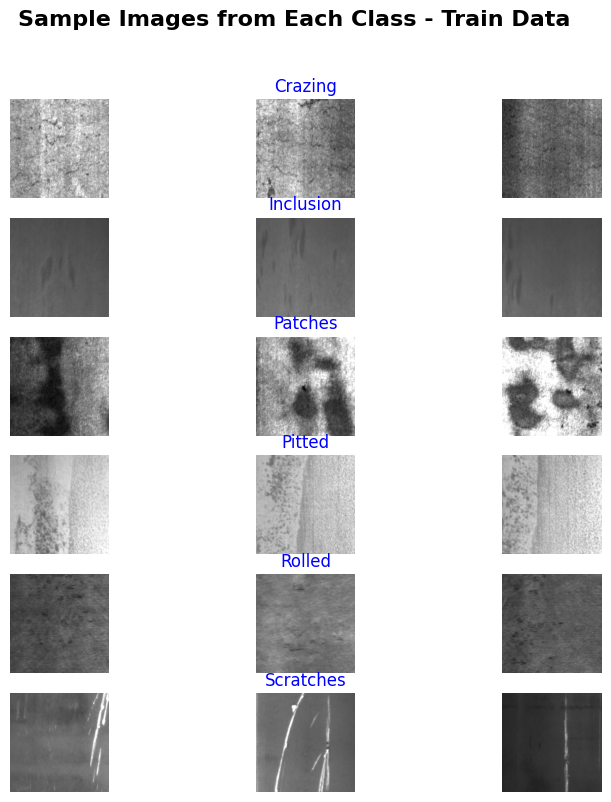

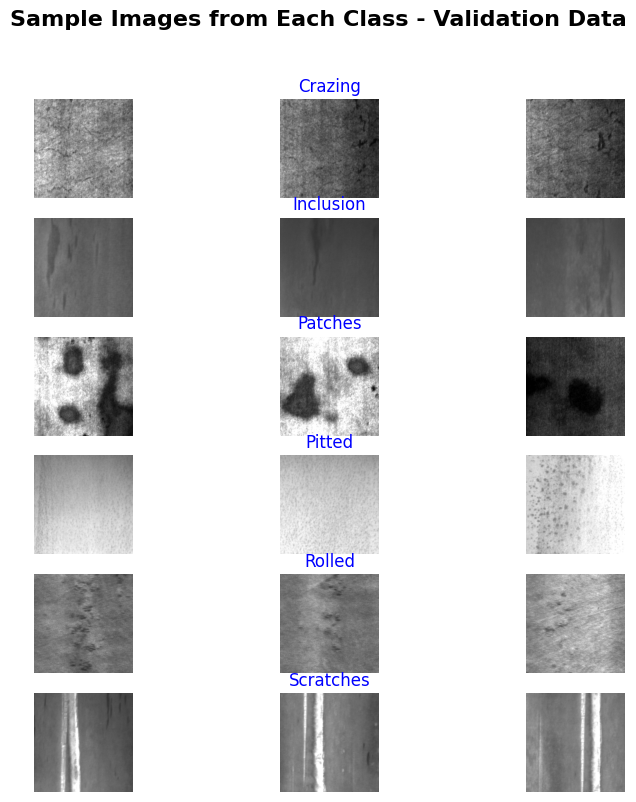

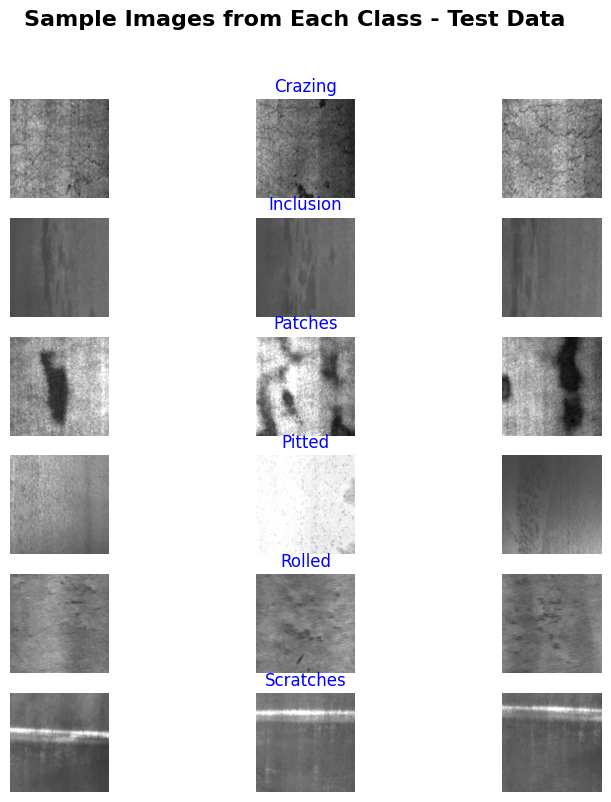

In [7]:
#Display sample images from each class

# Define dataset paths
raw_train = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\train'
raw_valid = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\valid'
raw_test = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\test'

# Function to get class names and image paths
def get_classwise_images(data_path):
    class_images = {}
    for defect_class in os.listdir(data_path):  # List subfolders (defect types)
        class_path = os.path.join(data_path, defect_class)
        if os.path.isdir(class_path):
            image_paths = glob(os.path.join(class_path, '*.bmp'))  # Get all image files
            class_images[defect_class] = image_paths
    return class_images

# Get image paths for datasets
train_images = get_classwise_images(raw_train)
valid_images = get_classwise_images(raw_valid)
test_images = get_classwise_images(raw_test)

# Display sample images from each class
def plot_sample_images(image_dict, dataset_name, num_samples=3):
    plt.figure(figsize=(9, num_samples * 3))
    
    for i, (label, images) in enumerate(image_dict.items()):
        if len(images) == 0:
            continue  # Skip empty classes
        sample_images = random.sample(images, min(num_samples, len(images)))  # Fix: Handle small class sizes
        
        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)  # Read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            plt.subplot(len(image_dict), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:  # Center title
                plt.title(label, fontsize=12, color='blue')
    
    plt.suptitle(f'Sample Images from Each Class - {dataset_name}', fontsize=16, fontweight='bold')
    plt.show()

# Plot images
plot_sample_images(train_images, "Train Data")
plot_sample_images(valid_images, "Validation Data")
plot_sample_images(test_images, "Test Data")

In [8]:
# Check image dimensions across dataset
def check_image_dimensions(image_dict):
    dimensions = []
    
    for images in image_dict.values():
        for img_path in images[:10]:  # Sample 10 images per class
            img = cv2.imread(img_path)
            dimensions.append(img.shape[:2])  # Get (height, width)

    dimensions = np.array(dimensions)
    unique_dims, counts = np.unique(dimensions, axis=0, return_counts=True)
    
    print("Unique Image Dimensions and Their Frequency:")
    for dim, count in zip(unique_dims, counts):
        print(f"Size: {dim} -> Count: {count}")

check_image_dimensions(train_images)

Unique Image Dimensions and Their Frequency:
Size: [200 200] -> Count: 60


In [9]:
# Check if images are grayscale or RGB
def check_color_channels(image_dict):
    img_path = random.choice(list(image_dict.values())[0])  # Pick a random image
    img = cv2.imread(img_path)
    
    if len(img.shape) == 2:
        print("Images are Grayscale.")
    elif len(img.shape) == 3:
        print(f"Images have {img.shape[2]} color channels (likely RGB or BGR).")

check_color_channels(train_images)

Images have 3 color channels (likely RGB or BGR).


<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">4) Data Preprocessing</span>
</div>

In [10]:
class DataPreprocessor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.train_mean = None
        self.train_std = None

    def resize_images(self, input_dir, output_dir):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        for root, _, files in os.walk(input_dir):
            for file_name in files:
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    file_path = os.path.join(root, file_name)
                    with Image.open(file_path) as img:
                        img = img.convert("RGB")  # Convert to RGB
                        resized_img = img.resize(self.target_size, Image.Resampling.LANCZOS)
                        relative_path = os.path.relpath(root, input_dir)
                        output_subdir = os.path.join(output_dir, relative_path)
                        if not os.path.exists(output_subdir):
                            os.makedirs(output_subdir)
                        output_path = os.path.join(output_subdir, file_name)
                        resized_img.save(output_path)
        print("Resizing complete.")
    
    
    def compute_normalization_stats(self, train_dataset_dir, is_train=True):
        """Computes mean and std of dataset in a memory-efficient way.
        Only computes for training data to avoid data leakage.
        """
        if not is_train:
            print("Skipping normalization computation for non-training data.")
            return
        
        pixel_sum = 0
        pixel_sq_sum = 0
        num_pixels = 0

        for root, _, files in os.walk(train_dataset_dir):
            for file_name in files:
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    file_path = os.path.join(root, file_name)
                    with Image.open(file_path) as img:
                        img_array = np.array(img) / 255.0  # Normalize pixels to [0,1]
                        pixel_sum += np.sum(img_array, axis=(0, 1))
                        pixel_sq_sum += np.sum(np.square(img_array), axis=(0, 1))
                        num_pixels += img_array.shape[0] * img_array.shape[1]

        self.train_mean = pixel_sum / num_pixels
        self.train_std = np.sqrt((pixel_sq_sum / num_pixels) - np.square(self.train_mean))
        print(f"Computed Train Mean: {self.train_mean}, Train Std: {self.train_std}")

    def normalize_image(self, img):
        return (img / 255.0 - self.train_mean) / self.train_std if self.train_mean is not None and self.train_std is not None else img / 255.0
    
    def augment_image_for_training(self, image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image
        
    def save(self, filename):
        """Save the preprocessor object using joblib."""
        joblib.dump(self, filename)
        print("Preprocessor saved to", filename)

    @staticmethod
    def load(filename):
        """Load the preprocessor object from joblib."""
        return joblib.load(filename)

In [11]:
# Define paths for raw and resized images
# The raw_* paths contain the original images, while the resize_* paths will store resized versions (224x224).
raw_train = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\train'
resize_train = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\resized_images_224\train'

raw_valid = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\valid'
resize_valid = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\resized_images_224\valid'

raw_test = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\test'
resize_test = r'd:\py\mlops\steel_crack\input_data\neu_metal_surface_defects_data\resized_images_224\test'

# Initialize the DataPreprocessor class, which handles image resizing and normalization
preprocessor = DataPreprocessor()

# Resize images in the train, validation, and test datasets
preprocessor.resize_images(raw_train, resize_train)
preprocessor.resize_images(raw_valid, resize_valid)
preprocessor.resize_images(raw_test, resize_test)

# Compute normalization statistics (mean and std) from the resized training dataset
# These stats are used to normalize images before feeding them into a deep learning model
preprocessor.compute_normalization_stats(train_dataset_dir=resize_train, is_train=True)

# Save the preprocessor object to a file for reuse (e.g., for normalizing new data using the same stats)
preprocessor.save("preprocessor.joblib")

Resizing complete.
Resizing complete.
Resizing complete.
Computed Train Mean: [0.50390848 0.50390848 0.50390848], Train Std: [0.21373386 0.21373386 0.21373386]
Preprocessor saved to preprocessor.joblib


In [12]:
class DatasetLoader:
    """
    A utility class for loading image datasets, normalizing images using precomputed statistics,
    and extracting class labels.

    Features:
    - Loads image datasets from a specified directory.
    - Normalizes images using precomputed mean and standard deviation.
    - Extracts class names and saves them to a JSON file.
    - Supports batch loading and resizing.

    Args:
    - preprocessor_path (str): Path to the precomputed normalization statistics (joblib file).
    - class_labels_path (str): Path to save extracted class labels in JSON format.
    - batch_size (int, optional): Number of images per batch. Default is 32.
    - image_size (tuple, optional): Target size for images (height, width). Default is (224, 224).
    - shuffle (bool, optional): Whether to shuffle the dataset. Default is True.

    Methods:
    - normalize(img): Normalizes an image using precomputed mean and standard deviation.
    - load_dataset(directory): Loads dataset, extracts class names if not already set, and applies normalization.
    - save_class_names(class_names): Saves extracted class names to a JSON file.
    """

    def __init__(self, preprocessor_path, class_labels_path, batch_size=32, image_size=(224, 224), shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.class_labels_path = class_labels_path

        # Load precomputed normalization statistics
        self.preprocessor = joblib.load(preprocessor_path)
        self.train_mean = self.preprocessor.train_mean
        self.train_std = self.preprocessor.train_std

        self.class_names = None

    def normalize(self, img):
        """Normalize an image using precomputed mean and standard deviation."""
        return (img - self.train_mean) / self.train_std

    def load_dataset(self, directory, is_training=False):
        """Load dataset, extract class names if not already set, and apply normalization."""
        dataset = image_dataset_from_directory(
            directory,
            batch_size=self.batch_size,
            image_size=self.image_size,
            shuffle=self.shuffle
        )

        # Extract and save class names only once
        if self.class_names is None:
            self.class_names = dataset.class_names
            self.save_class_names(self.class_names)

        # Apply normalization to dataset
        def preprocess(image, label):
            image = tf.cast(image, tf.float32) / 255.0
            image = self.normalize(image)
            if is_training:
                image = self.preprocessor.augment_image_for_training(image)  # Apply augmentation

            return image, label

        return dataset.map(preprocess)

    def save_class_names(self, class_names):
        """Save extracted class names to a JSON file."""
        with open(self.class_labels_path, "w") as f:
            json.dump(class_names, f)


In [13]:
# Define paths
preprocessor_path = "preprocessor.joblib"
class_labels_path = "class_labels.json"

# Initialize dataset loader
dataset_loader = DatasetLoader(preprocessor_path, class_labels_path)

# Load training, validation, and test datasets
train_ds = dataset_loader.load_dataset(resize_train, is_training=True)
valid_ds = dataset_loader.load_dataset(resize_valid, is_training=False)
test_ds = dataset_loader.load_dataset(resize_test, is_training=False)

# Print extracted class labels
print("Class labels mapping:", dataset_loader.class_names)

Found 1656 files belonging to 6 classes.
Found 72 files belonging to 6 classes.
Found 72 files belonging to 6 classes.
Class labels mapping: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [14]:
# Iterate over the test dataset and take one batch of images and labels
for images, labels in test_ds.take(1):  # Take the first batch from the dataset
    # Print the shape of the image batch (e.g., batch_size, height, width, channels)
    print("Image batch shape:", images.shape)
    
    # Print the shape of the label batch (should match the batch size)
    print("Label batch shape:", labels.shape)
    
    # Convert labels to a NumPy array and print the unique label values in the batch
    # This helps verify which classes are present in the current batch
    print("Unique labels in the batch:", np.unique(labels.numpy()))

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Unique labels in the batch: [0 1 2 3 4 5]


In [15]:
# Initialize an empty set to store unique labels
unique_labels = set()

# Iterate through the training dataset to collect unique labels
for _, label in train_ds:
    # Convert the label tensor to a list and update the set with unique values
    unique_labels.update(label.numpy().tolist())  

# Print the unique labels found in the training dataset
print("Unique labels in train_ds:", unique_labels)

# Print the total number of unique labels
print("Number of unique labels:", len(unique_labels))

Unique labels in train_ds: {0, 1, 2, 3, 4, 5}
Number of unique labels: 6


<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">5) Model Building</span>
</div>

In [16]:
"""
ModelBuilder Class for Building Pretrained and Custom CNN Models

This class allows easy construction of image classification models using:
- Pretrained models (VGG16, ResNet50, MobileNetV2, EfficientNetB0) with transfer learning options
- A custom CNN model

Key Features:
- Freezing layers for transfer learning
- Adding a classification head
- Supports multiple architectures with a consistent interface

""";

class ModelBuilder:
    def __init__(self, model_name, input_shape, num_classes, learning_rate=0.001, include_top=False, freeze_all=True, freeze_till=None):
        """
        Initialize ModelBuilder.

        Parameters:
        - model_name (str): Name of the model ('vgg16', 'resnet50', 'mobilenetv2', 'efficientnetb0', or 'custom_cnn')
        - input_shape (tuple): Shape of the input image (height, width, channels)
        - num_classes (int): Number of output classes
        - learning_rate (float): Learning rate for the optimizer
        - include_top (bool): Whether to include the fully connected layer of the pretrained model
        - freeze_all (bool): If True, freezes all layers of the pretrained model
        - freeze_till (int or None): Number of layers from the end to keep trainable (None means all frozen)
        """
        self.model_name = model_name
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.include_top = include_top
        self.freeze_all = freeze_all
        self.freeze_till = freeze_till
        self.model = None

    def get_base_model(self):
        """Load a pretrained model or build a custom CNN."""
        if self.model_name.lower() == "vgg16":
            base_model = tf.keras.applications.VGG16(input_shape=self.input_shape, weights="imagenet", include_top=self.include_top)
        elif self.model_name.lower() == "resnet50":
            base_model = tf.keras.applications.ResNet50(input_shape=self.input_shape, weights="imagenet", include_top=self.include_top)
        elif self.model_name.lower() == "mobilenetv2":
            base_model = tf.keras.applications.MobileNetV2(input_shape=self.input_shape, weights="imagenet", include_top=self.include_top)
        elif self.model_name.lower() == "efficientnetb0":
            base_model = tf.keras.applications.EfficientNetB0(input_shape=self.input_shape, weights="imagenet", include_top=self.include_top)
        elif self.model_name.lower() == "custom_cnn":
            return self.build_custom_cnn()  # Return a custom CNN model
        else:
            raise ValueError("Unsupported model name. Choose from 'VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0', or 'custom_cnn'.")

        # Apply transfer learning settings (freeze layers as needed)
        base_model = self._freeze_layers(base_model)
        return base_model

    def _freeze_layers(self, model):
        """Freeze layers based on configuration for transfer learning."""
        if self.freeze_all:
            for layer in model.layers:
                layer.trainable = False  # Freeze all layers
        elif self.freeze_till is not None and self.freeze_till > 0:
            for layer in model.layers[:-self.freeze_till]:
                layer.trainable = False  # Freeze only specific layers
        return model

    def _add_classification_head(self, base_model):
        """Attach a classification head to the base model."""
        flatten = layers.Flatten()(base_model.output)
        dense = layers.Dense(256, activation="relu")(flatten)
        dropout = layers.Dropout(0.5)(dense)
        output = layers.Dense(self.num_classes, activation="softmax")(dropout)

        model = tf.keras.Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=self.learning_rate),
                      loss=tf.keras.losses.sparse_categorical_crossentropy,
                      metrics=["accuracy"])
        return model

    def build_custom_cnn(self):
        """Define and build a custom CNN model."""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss=tf.keras.losses.sparse_categorical_crossentropy,
                      metrics=["accuracy"])
        return model

    def build_model(self):
        """Build and return the final model."""
        base_model = self.get_base_model()
        if self.model_name.lower() == "custom_cnn":
            self.model = base_model  # Custom CNN is already fully built
        else:
            self.model = self._add_classification_head(base_model)
        return self.model

In [17]:
# Create a VGG16-based model using the ModelBuilder class
# - "vgg16" specifies the model type
# - input_shape=(224, 224, 3) defines the image dimensions (224x224 pixels, 3 color channels)
# - num_classes=6 sets the number of output classes
# - learning_rate=0.001 defines the initial learning rate for training
vgg16_builder = ModelBuilder("vgg16", input_shape=(224, 224, 3), num_classes=6, learning_rate=0.001)

# Build the VGG16 model
vgg16_model = vgg16_builder.build_model()

# Create a custom CNN model using the ModelBuilder class with the same parameters
custom_cnn_builder = ModelBuilder("custom_cnn", input_shape=(224, 224, 3), num_classes=6, learning_rate=0.001)

# Build the custom CNN model
custom_cnn_model = custom_cnn_builder.build_model()

In [18]:
# Dictionary to store models
models_dict = {
    "vgg16": vgg16_model,
    "custom_cnn": custom_cnn_model
}

# Display model architecture
for model_name, model in models_dict.items():
    print(f"\nModel: {model_name}")
    model.summary()


Model: vgg16


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Model: custom_cnn


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,681,606 (36.93 MB)

 Trainable params: 9,681,606 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">6) Preparing Callbacks</span>
</div>

In [19]:
class PrepareCallback:
    """
    A class to create and manage TensorFlow training callbacks.

    This class provides:
    - TensorBoard logging for visualization.
    - ModelCheckpoint to save the best model.
    - EarlyStopping to stop training when validation loss stops improving.
    - ReduceLROnPlateau to reduce the learning rate when validation performance plateaus.

    Attributes:
        tensorboard_log_dir (str): Directory to save TensorBoard logs.
        checkpoint_filepath (str): File path to save the best model checkpoint.
        patience (int): Number of epochs to wait before stopping training (default: 5).
        factor (float): Factor to reduce the learning rate when performance plateaus (default: 0.1).
    """

    def __init__(self, tensorboard_log_dir, checkpoint_filepath, patience=5, factor=0.1):
        """Initializes the PrepareCallback class with necessary parameters."""
        self.tensorboard_log_dir = tensorboard_log_dir
        self.checkpoint_filepath = checkpoint_filepath
        self.patience = patience
        self.factor = factor

    def clear_tensorboard_logs(self):
        """Deletes old TensorBoard logs before creating a new run."""
        if os.path.exists(self.tensorboard_log_dir):
            shutil.rmtree(self.tensorboard_log_dir)  # Remove old logs
        os.makedirs(self.tensorboard_log_dir, exist_ok=True)  # Create fresh log directory


    def create_tensorboard_callback(self):
        """Clears old logs and creates a TensorBoard callback with a new log directory."""
        self.clear_tensorboard_logs()  # Remove previous logs
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(self.tensorboard_log_dir, f"tb_logs_at_{timestamp}")
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)

    def create_checkpoint_callback(self):
        """Creates a ModelCheckpoint callback to save the best model during training."""
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=self.checkpoint_filepath,
            save_best_only=True
        )

    def create_early_stopping_callback(self):
        """Creates an EarlyStopping callback to stop training if validation loss doesn't improve."""
        return tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=self.patience,
            restore_best_weights=True
        )

    def create_reduce_lr_callback(self):
        """Creates a ReduceLROnPlateau callback to reduce learning rate when validation loss stops improving."""
        return tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=self.factor,
            patience=self.patience // 2,
            verbose=1
        )

    def get_callbacks(self):
        """Returns a list of all defined callbacks."""
        return [
            self.create_tensorboard_callback(),
            self.create_checkpoint_callback(),
            self.create_early_stopping_callback(),
            self.create_reduce_lr_callback()
        ]

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">7) Base Model Training, Evaluation and Selecting the Best Performing Base Model</span>
</div>

In [20]:
class ModelTrainer:
    """
    ModelTrainer class is responsible for training multiple models, evaluating their performance,
    and selecting the best model based on a weighted scoring system.
    
    Attributes:
    - models_dict: Dictionary of model names and their corresponding TensorFlow models.
    - train_ds: Training dataset.
    - valid_ds: Validation dataset.
    - class_labels_path: Path to the JSON file containing class labels.
    - class_names: List of class names loaded from the JSON file.
    - results: Dictionary to store evaluation metrics for each trained model.
    """
    
    def __init__(self, models_dict, train_ds, valid_ds, class_labels_path, best_base_model_path):
        self.models_dict = models_dict
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.class_labels_path = class_labels_path
        self.class_names = self.load_class_labels()
        self.best_base_model_path = best_base_model_path
        self.results = {}

    def load_class_labels(self):
        """Load class labels from a JSON file."""
        with open(self.class_labels_path, "r") as f:
            return json.load(f)

    def train_and_evaluate(self):
        """
        Train all models in self.models_dict, evaluate their performance on the validation dataset,
        and store their metrics in self.results.
        """
        for model_name, model in self.models_dict.items():
            print(f"Training {model_name}...")
            
            # Create a unique callback instance for each model
            callbacks = PrepareCallback(
                tensorboard_log_dir=f"logs/{model_name}",  # Separate log directory for each model
                checkpoint_filepath=f"checkpoints/{model_name}.keras"  # Unique checkpoint file for each model
            ).get_callbacks()
                          

            # Train model and capture training history
            history = model.fit(self.train_ds, validation_data=self.valid_ds, epochs=10, verbose=1, callbacks=callbacks)

            # Extract metrics from history (last epoch values)
            train_acc = history.history["accuracy"][-1]  # Last epoch training accuracy
            val_acc = history.history["val_accuracy"][-1]  # Last epoch validation accuracy
            val_loss = history.history["val_loss"][-1]  # Last epoch validation loss

            # Extract true and predicted labels from the validation dataset
            y_true, y_pred = self._get_true_and_pred_labels(model, self.valid_ds)

            # Calculate additional performance metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='weighted')
            recall = recall_score(y_true, y_pred, average='weighted')
            f1 = f1_score(y_true, y_pred, average='weighted')
            conf_matrix = confusion_matrix(y_true, y_pred)
            class_report = classification_report(y_true, y_pred, target_names=self.class_names)

            # Store evaluation results
            self.results[model_name] = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "classification_report": class_report,
                #"confusion_matrix": conf_matrix.tolist(),
                "train_accuracy": train_acc,
                "validation_loss": val_loss,
                "validation_accuracy": val_acc
            }

            # Display metrics
            print(f"\nModel: {model_name}")
            print(f"Accuracy: {accuracy:.4f}")
            print("Classification Report:\n", class_report)
            
            # Plot Confusion Matrix
            self._plot_confusion_matrix(conf_matrix, model_name)

        # Save results to JSON file
        with open("base_model_results.json", "w") as f:
            json.dump(self.results, f, indent=4)

    def _get_true_and_pred_labels(self, model, dataset):
        """Extract true labels and predicted labels from a TensorFlow dataset."""
        y_true, y_pred = [], []
        
        for batch in dataset:
            X_batch, y_batch = batch  # Unpack batch
            y_true.extend(y_batch.numpy().astype(int).flatten())  # Convert tensor to numpy array
            preds = model.predict(X_batch)  # Get predictions
            y_pred.extend(np.argmax(preds, axis=1))  # Convert probabilities to class labels

        return np.array(y_true), np.array(y_pred)

    def _plot_confusion_matrix(self, conf_matrix, model_name):
        """Plot the confusion matrix as a heatmap."""
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(f"Confusion Matrix - {model_name}")
        filename = f"base_model_{model_name.lower()}_valid_ds_confusion_matrix.jpg"
        plt.savefig(filename, bbox_inches="tight", dpi=300)
        print(f"Confusion matrix saved as {filename}")

        plt.show()

    def get_best_model(self):
        """
        Select the best-performing model based on a weighted scoring system.
        
        The scoring formula considers:
        - Validation Accuracy: Higher accuracy is better.
        - Validation Loss: Lower loss indicates better generalization.
        - Overfitting Penalty: Models with a large gap between training and validation accuracy are penalized.
        
        The model with the highest adjusted score is selected.
        """
        def score_model(model_name, result):
            val_acc = result["accuracy"]  # Validation accuracy
            val_loss = result["validation_loss"]  # Validation loss
            train_acc = result["train_accuracy"]  # Training accuracy
            
            # Overfitting penalty: Absolute difference between training and validation accuracy
            overfit_penalty = abs(train_acc - val_acc)  
            
            # Weighted scoring formula
            score = val_acc - overfit_penalty - (val_loss * 0.1)  # Val loss is scaled to prevent dominance
            return score

        # Find the model with the highest adjusted score
        best_model_name = max(self.results, key=lambda k: score_model(k, self.results[k]))

        # Save the best model name to a JSON file
        with open(self.best_base_model_path, "w") as f:
            json.dump({"best_base_model": best_model_name}, f, indent=4)

        print(f"Best Performing Base Model: {best_model_name} with Adjusted Score: {score_model(best_model_name, self.results[best_model_name]):.4f}")
        return best_model_name, self.models_dict[best_model_name]

Training vgg16...
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.3008 - loss: 1.7509 - val_accuracy: 0.7778 - val_loss: 1.1164 - learning_rate: 0.0010
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.6721 - loss: 1.0787 - val_accuracy: 0.9028 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.7945 - loss: 0.8037 - val_accuracy: 0.9583 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8520 - loss: 0.6409 - val_accuracy: 1.0000 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.9003 - loss: 0.5435 - val_accuracy: 0.9722 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9154 - loss: 0.4573 - val_accuracy: 0.9861 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9249 - loss

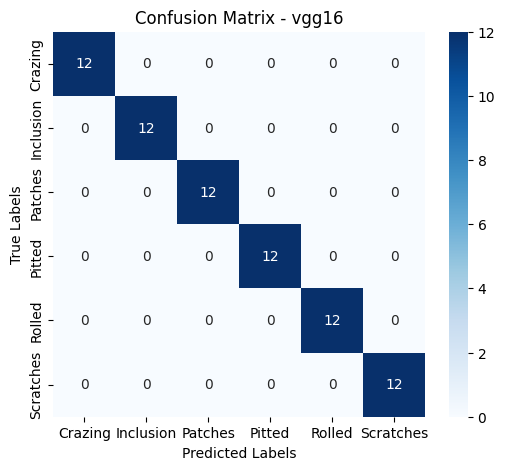

Training custom_cnn...
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 776ms/step - accuracy: 0.3459 - loss: 1.6082 - val_accuracy: 0.6667 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 737ms/step - accuracy: 0.7062 - loss: 0.7840 - val_accuracy: 0.9444 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 723ms/step - accuracy: 0.8740 - loss: 0.3871 - val_accuracy: 0.9722 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 664ms/step - accuracy: 0.9042 - loss: 0.2985 - val_accuracy: 0.9028 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9171 - loss: 0.2395
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 674ms/step - accuracy: 0.9167 - loss: 0.2402 - val_accuracy: 0.9306 - val_loss: 0.2077 - learning_rate: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 703ms/step - accur

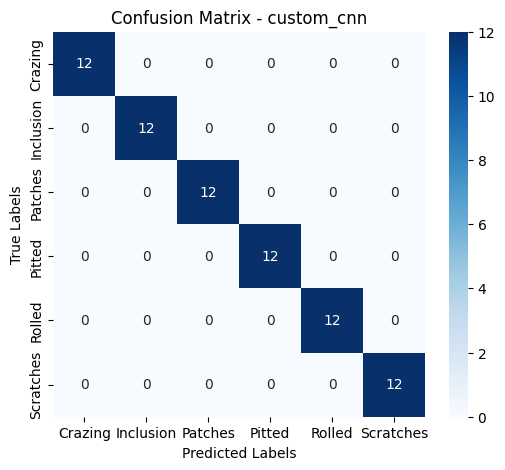

Best Performing Base Model: custom_cnn with Adjusted Score: 0.9472


In [21]:
# Create ModelTrainer instance
trainer = ModelTrainer(models_dict, train_ds, valid_ds, class_labels_path = "class_labels.json", best_base_model_path = "best_base_model.json")

# Train and evaluate models
trainer.train_and_evaluate()

# Get the best performing model
best_model_name, best_model = trainer.get_best_model()

In [22]:
'''
# Load the TensorBoard extension in Jupyter Notebook
%load_ext tensorboard  

# Start TensorBoard and specify the log directory, host, and port  
%tensorboard --logdir logs --host localhost --port 6006  

# Reload the TensorBoard extension if it is already loaded  
%reload_ext tensorboard  

# Check if TensorBoard is already running on port 6006 and find its Process ID (PID)  
!netstat -ano | findstr :6006  

# Kill the existing TensorBoard process (replace 14504 with the actual PID found in the previous command)  
!taskkill /PID 14504 /F  

# Run TensorBoard from the command line (use this if running outside Jupyter Notebook)  
tensorboard --logdir "D:/py/mlops/steel_crack/logs" --host localhost --port 6006  

# At command prompt
!tensorboard --logdir logs --host localhost --port 6006
''';

In [23]:
# Load TensorBoard extension (only needed once per session)
%load_ext tensorboard  

# Launch TensorBoard (ensure logs are being written to the specified path)
%tensorboard --logdir "logs" --host localhost --port 6006  

Reusing TensorBoard on port 6006 (pid 7448), started 1:14:46 ago. (Use '!kill 7448' to kill it.)

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">8) Hyperparameter Tuning</span>
</div>

In [24]:
"""
ModelTuner class for fine-tuning an image classification model using Keras Tuner.

- Initializes with a dictionary of models and a selected base model.
- Uses Bayesian Optimization to tune hyperparameters.
- Evaluates the best model on validation and test datasets.
- Saves evaluation results and plots confusion matrices.
""";

class ModelTuner:
    def __init__(self, models_dict, best_base_model_name, train_ds, valid_ds, test_ds, 
                 img_shape=(224, 224, 3), num_classes=6, max_trials=5, epochs=10, 
                 class_labels_path="class_labels.json", results_path="tuned_model_results.json", 
                 model_path="tuned_model.h5"):
        
        self.models_dict = models_dict  # Available model architectures
        self.best_base_model_name = best_base_model_name  # Selected base model
        self.train_ds = train_ds  # Training dataset
        self.valid_ds = valid_ds  # Validation dataset
        self.test_ds = test_ds  # Test dataset
        self.img_shape = img_shape  # Input image dimensions
        self.num_classes = num_classes  # Number of output classes
        self.max_trials = max_trials  # Number of hyperparameter tuning trials
        self.epochs = epochs  # Training epochs for tuning
        self.class_labels_path = class_labels_path  # Path to class labels JSON file
        self.results_path = results_path  # Path to store evaluation results
        self.model_path = model_path  # Path to save the tuned model
        self.tuner = None  # Keras Tuner instance (initialized later)
        self.base_model = self._get_base_model()  # Retrieve and freeze base model

    def _get_base_model(self):
        """Retrieves the specified base model and freezes it if necessary."""
        if self.best_base_model_name not in self.models_dict:
            raise ValueError(f"Invalid base model: {self.best_base_model_name}")

        base_model = self.models_dict[self.best_base_model_name]
        
        if isinstance(base_model, keras.Sequential):  # Custom CNN model
            return base_model
        elif isinstance(base_model, Model):  # Pretrained model
            base_model.trainable = False  # Freeze the model
            return base_model
        else:
            raise TypeError("Unsupported model type. Must be Sequential or Model.")

    def build_tuned_model(self, hp):
        """Builds a model with tunable hyperparameters."""
        inputs = layers.Input(shape=self.img_shape)
        x = self.base_model(inputs, training=False)  # Ensure compatibility with functional API
        
        if len(x.shape) == 2:  # If output is a flattened vector, skip pooling
            x = layers.Dense(hp.Int("dense_units", min_value=128, max_value=512, step=64), activation="relu")(x)
        else:
            x = layers.GlobalAveragePooling2D()(x)
            x = layers.Dense(hp.Int("dense_units", min_value=128, max_value=512, step=64), activation="relu")(x)
        
        x = layers.Dropout(hp.Float("dropout_rate", min_value=0.2, max_value=0.6, step=0.1))(x)
        outputs = layers.Dense(self.num_classes, activation="softmax")(x)

        model = Model(inputs, outputs)
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        return model

    def tune_model(self):
        """Tunes the model using Bayesian Optimization."""
        model_name = f"tuned_{self.best_base_model_name}"
        
        # Define callbacks for logging and checkpointing
        callbacks = PrepareCallback(
            tensorboard_log_dir=f"logs/{model_name}",
            checkpoint_filepath=f"checkpoints/{model_name}.keras"
        ).get_callbacks()

        temp_dir = tempfile.mkdtemp()  # Temporary directory for tuner results
        self.tuner = kt.BayesianOptimization(
            self.build_tuned_model,
            objective="val_accuracy",
            max_trials=self.max_trials,
            num_initial_points=3,
            directory=temp_dir,  # Store results in a temporary directory
            project_name=None
            #directory="tuner_results",
            #project_name="image_classification_bayesian"            
        )
        
        self.tuner.search(self.train_ds, validation_data=self.valid_ds, epochs=self.epochs, callbacks=callbacks)
        
        # Retrieve and print best hyperparameters
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best hyperparameters: Dense units = {best_hps.get('dense_units')}, Dropout rate = {best_hps.get('dropout_rate')}")

    def evaluate_model(self):
        """Evaluates the best model and saves results."""
        with open(self.class_labels_path, "r") as f:
            class_labels = json.load(f)

        best_model = self.tuner.get_best_models(num_models=1)[0]
        
        def evaluate_dataset(dataset, dataset_name):
            """Evaluates model on a dataset and returns performance metrics."""
            y_true, y_pred = [], []
            
            for images, labels in dataset:
                preds = best_model.predict(images)
                y_true.extend(labels.numpy())
                y_pred.extend(np.argmax(preds, axis=1))
            
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='weighted')
            recall = recall_score(y_true, y_pred, average='weighted')
            f1 = f1_score(y_true, y_pred, average='weighted')
            conf_matrix = confusion_matrix(y_true, y_pred)
            class_report = classification_report(y_true, y_pred, target_names=class_labels)
            
            self._plot_confusion_matrix(conf_matrix, class_labels, dataset_name)
            
            return {
                "dataset": dataset_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "classification_report": class_report,
            }
        
        validation_results = evaluate_dataset(self.valid_ds, "Validation")
        test_results = evaluate_dataset(self.test_ds, "Test")
        
        evaluation_results = {"validation": validation_results, "test": test_results}
        
        with open(self.results_path, "w") as json_file:
            json.dump(evaluation_results, json_file, indent=4)
        print(f"Evaluation results saved to {self.results_path}")

        best_model.save(self.model_path)
        print(f"Tuned model saved to {self.model_path}")
        
        return evaluation_results

    def _plot_confusion_matrix(self, conf_matrix, class_labels, dataset_name):
        """Plots and saves the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {dataset_name} Dataset")
        filename = f"tuned_model_{dataset_name.lower()}_confusion_matrix.jpg"
        plt.savefig(filename, bbox_inches="tight", dpi=300)
        print(f"Confusion matrix saved as {filename}")
        plt.show()


Trial 5 Complete [00h 06m 27s]
val_accuracy: 0.6111111044883728

Best val_accuracy So Far: 0.7777777910232544
Total elapsed time: 00h 30m 33s
Best hyperparameters: Dense units = 128, Dropout rate = 0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Confusion matrix saved as tuned_model_validation_confusion_matrix.jpg


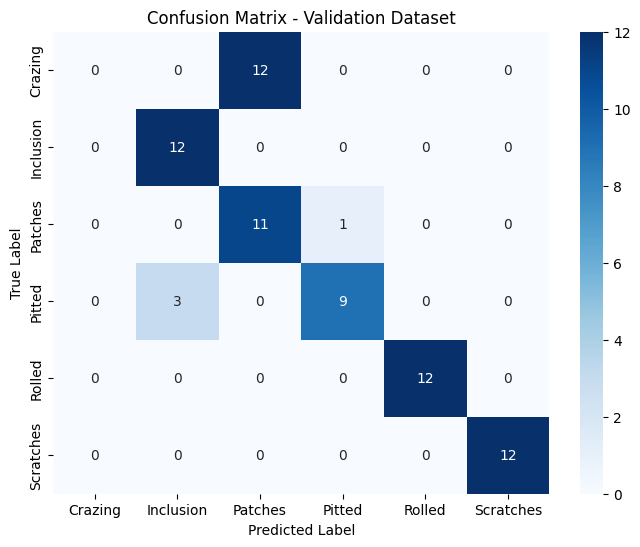

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Confusion matrix saved as tuned_model_test_confusion_matrix.jpg


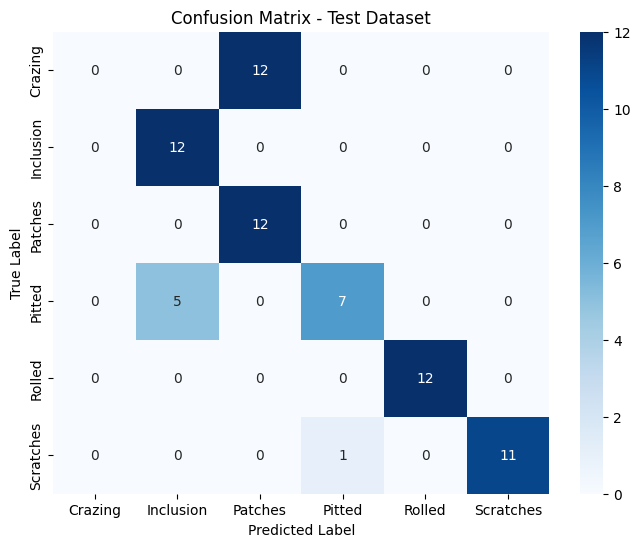

Evaluation results saved to tuned_model_results.json
Tuned model saved to tuned_model.h5


{'validation': {'dataset': 'Validation',
  'accuracy': 0.7777777777777778,
  'precision': 0.696376811594203,
  'recall': 0.7777777777777778,
  'f1_score': 0.7226070226070226,
  'classification_report': '              precision    recall  f1-score   support\n\n     Crazing       0.00      0.00      0.00        12\n   Inclusion       0.80      1.00      0.89        12\n     Patches       0.48      0.92      0.63        12\n      Pitted       0.90      0.75      0.82        12\n      Rolled       1.00      1.00      1.00        12\n   Scratches       1.00      1.00      1.00        12\n\n    accuracy                           0.78        72\n   macro avg       0.70      0.78      0.72        72\nweighted avg       0.70      0.78      0.72        72\n'},
 'test': {'dataset': 'Test',
  'accuracy': 0.75,
  'precision': 0.6801470588235294,
  'recall': 0.75,
  'f1_score': 0.6917957687822756,
  'classification_report': '              precision    recall  f1-score   support\n\n     Crazing      

In [25]:
# Initialize the ModelTuner class with the necessary parameters, including 
# model architectures, dataset splits, and hyperparameter tuning settings.
tuner = ModelTuner(models_dict, best_model_name, train_ds, valid_ds, test_ds)

# Start the hyperparameter tuning process using Bayesian Optimization.
# This will search for the best combination of hyperparameters.
tuner.tune_model()

# Evaluate the best-tuned model on validation and test datasets.
# Saves evaluation metrics, classification reports, and confusion matrices.
tuner.evaluate_model()

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">9) Prediction for a Single Image</span>
</div>

In [26]:
def predict_image(image_path, model_path="tuned_model.h5", preprocessor_path="preprocessor.joblib", class_labels_path="class_labels.json"):
    """
    Predicts the class of a given input image using the fine-tuned model.
    
    Parameters:
        image_path (str): Path to the input image.
        model_path (str): Path to the saved trained model.
        preprocessor_path (str): Path to the preprocessor file.
        class_labels_path (str): Path to the JSON file containing class labels.

    Returns:
        str: Predicted class label with confidence score.
    """

    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Load the preprocessor
    preprocessor = joblib.load(preprocessor_path)

    # Load class labels
    with open(class_labels_path, "r") as f:
        class_labels = json.load(f)

    # Load and preprocess the input image
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        img = img.resize(preprocessor.target_size, Image.Resampling.LANCZOS)  # Resize to target size

    img_array = np.array(img) / 255.0  # Convert to array and scale to [0,1]

    # Apply normalization if mean and std are computed
    if preprocessor.train_mean is not None and preprocessor.train_std is not None:
        img_array = preprocessor.normalize_image(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)  # Get confidence score

    # Return predicted class and confidence score
    return f"Predicted Class: {class_labels[predicted_class]} (Confidence: {confidence:.2f})"

In [37]:
result = predict_image(r"input_data\neu_metal_surface_defects_data\test\Pitted\PS_101.bmp")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted Class: Pitted (Confidence: 0.60)


<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">10) Building the Application</span>


</div>

- Designed a Streamlit web application allowing users to: <br>
  - 📸 Upload images for defect classification. <br>
  - 📊 View classification results with confidence scores. <br>

Refer to the complete project on GitHub: https://github.com/Pradeep-Yarava/metal-surface-defect-detection-cnn

<div style="background-color:#F3E5F5; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">11) Deployment</span>
</div>

- 🐳 **Docker Deployment:**
  - Model is deployed using **Docker**.
  - CI/CD pipeline implemented using **GitHub Actions** to automate deployment.

- 🌐 **Render Deployment:**
  - Model is also deployed on **Render** for real-time accessibility.

---

- 📂 **GitHub Repository**

Refer to the complete project on GitHub:https://github.com/Pradeep-Yarava/metal-surface-defect-detection-cnn.

- 🌐 **Render Link**

View Application on Render: